# Setup

In [ ]:
import numpy as np
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, \
                    classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, Model, optimizers


from tqdm.auto import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
os.chdir("/content/drive/MyDrive/DiabeticRetinopathyDetection")

# Hyperprameters

In [ ]:
IMAGE_SIZE = 150
BASE_MODEL = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

171446536/171446536 [==============================] - 6s 0us/step


# Loading features

In [ ]:
labeled_data_features = np.load("data/processed/train/features/labeled_data_features.npy")
print("Loaded features", labeled_data_features.shape)

Loaded features (35122, 51200)


In [ ]:
labeled_data = pd.read_csv("data/ext/trainlabels.csv")

labeled_data_labels = labeled_data['level']

print("labeled data labels", len(labeled_data_labels))
print("Class distribution before balancing:", Counter(labeled_data_labels))

labeled data labels 35122
Class distribution before balancing: Counter({0: 25808, 2: 5291, 1: 2442, 3: 873, 4: 708})


# Balancing via SMOTE

In [ ]:
# Set the target number of samples for each class
target_samples = 7000

# Upsample the minority classes (classes 1, 2, 3, and 4) using SMOTE
smote = SMOTE(sampling_strategy={1: target_samples, 2: target_samples, 3: target_samples, 4: target_samples})
oversampled_features, oversampled_labels = smote.fit_resample(labeled_data_features, labeled_data_labels)

# Downsample the majority class (class 0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={0: target_samples})
undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 7000, 1: 7000, 2: 7000, 3: 7000, 4: 7000})
Shape of oversampled features: (35000,)
Shape of oversampled labels: (35000,)


In [ ]:
np.save("data/experiments/experiment5/features.npy", undersampled_features)
np.save("data/experiments/experiment5/labels.npy", undersampled_labels)

print("Features saved at data/experiments/experiment5/features.npy")
print("Labels saved at data/experiments/experiment5/labels.npy")

Features saved at data/experiments/experiment4/features.npy
Labels saved at data/experiments/experiment4/labels.npy


# Data Split

In [ ]:
undersampled_features = np.load("data/experiments/experiment5/features.npy")
undersampled_labels = np.load("data/experiments/experiment5/labels.npy")

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 7000, 1: 7000, 2: 7000, 3: 7000, 4: 7000})
Shape of oversampled features: (35000,)
Shape of oversampled labels: (35000,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    undersampled_features, undersampled_labels,
    stratify=undersampled_labels,
    test_size=0.2, random_state=42
)

# Model Training on labeled data

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
classifier = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(512),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(5, activation='softmax')
])

classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = classifier.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val))

Epoch 1/50
875/875 [==============================] - 25s 23ms/step - loss: 1.1363 - accuracy: 0.5111 - val_loss: 0.8441 - val_accuracy: 0.6357
Epoch 2/50
875/875 [==============================] - 17s 20ms/step - loss: 0.7612 - accuracy: 0.6689 - val_loss: 0.6643 - val_accuracy: 0.7104
Epoch 3/50
875/875 [==============================] - 17s 20ms/step - loss: 0.6234 - accuracy: 0.7371 - val_loss: 0.6375 - val_accuracy: 0.7283
Epoch 4/50
875/875 [==============================] - 17s 20ms/step - loss: 0.5162 - accuracy: 0.7868 - val_loss: 0.5370 - val_accuracy: 0.7659
Epoch 5/50
875/875 [==============================] - 17s 20ms/step - loss: 0.4314 - accuracy: 0.8235 - val_loss: 0.6015 - val_accuracy: 0.7533
Epoch 6/50
875/875 [==============================] - 17s 20ms/step - loss: 0.3628 - accuracy: 0.8559 - val_loss: 0.5339 - val_accuracy: 0.7869
Epoch 7/50
875/875 [==============================] - 18s 20ms/step - loss: 0.3072 - accuracy: 0.8776 - val_loss: 0.5551 - val_accuracy:

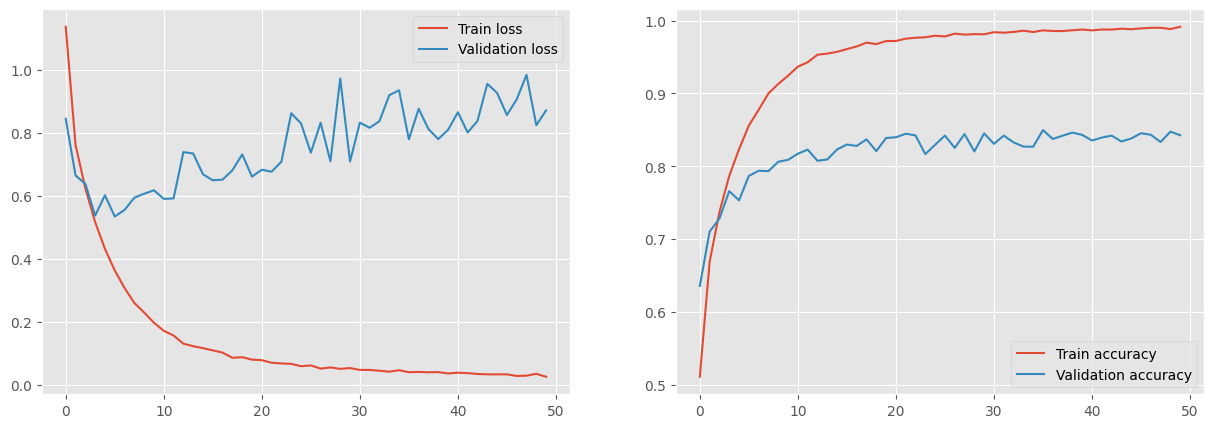

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
np.save(f"data/experiments/experiment5/X_train.npy", X_train)
np.save(f"data/experiments/experiment5/y_train.npy", y_train)

np.save(f"data/experiments/experiment5/X_val.npy", X_val)
np.save(f"data/experiments/experiment5/y_val.npy", y_val)

classifier.save(f"data/experiments/experiment5/classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# KNN Model training

In [ ]:
X_train = np.load(f"data/experiments/experiment5/X_train.npy")
y_train = np.load(f"data/experiments/experiment5/y_train.npy")

X_val = np.load(f"data/experiments/experiment5/X_val.npy")
y_val = np.load(f"data/experiments/experiment5/y_val.npy")

In [ ]:
y_train_straight = np.argmax(y_train, axis=1)
y_val_straight = np.argmax(y_val, axis=1)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_straight)

print(f"Training Accuracy: {knn.score(X_train, y_train_straight)})")
print(f"Validation Accuracy: {knn.score(X_val, y_val_straight)})")

Training Accuracy: 0.7416785714285714)
Validation Accuracy: 0.6655714285714286)


In [ ]:
pickle.dump(knn, open('data/experiments/experiment5/knn.sav', 'wb'))

# Evaluating on Validation set

In [ ]:
X_train = np.load(f"data/experiments/experiment5/X_train.npy")
y_train = np.load(f"data/experiments/experiment5/y_train.npy")

X_val = np.load(f"data/experiments/experiment5/X_val.npy")
y_val = np.load(f"data/experiments/experiment5/y_val.npy")

classifier = tf.keras.models.load_model(f"data/experiments/experiment5/classifier.h5")
knn = pickle.load(open('data/experiments/experiment5/knn.sav', 'rb'))

## Classifier

In [ ]:
train_loss, train_acc = classifier.evaluate(X_train, y_train)
val_loss, val_acc = classifier.evaluate(X_val, y_val)

print('Training Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)

219/219 [==============================] - 11s 51ms/step - loss: 0.8710 - accuracy: 0.8427
Training Accuracy: 0.9991071224212646
Validation Accuracy: 0.8427143096923828


## KNN

In [ ]:
y_train_straight = np.argmax(y_train, axis=1)
y_val_straight = np.argmax(y_val, axis=1)

In [ ]:
print(f"Training Accuracy: {knn.score(X_train, y_train_straight)})")
print(f"Validation Accuracy: {knn.score(X_val, y_val_straight)})")

Training Accuracy: 0.7416785714285714)
Validation Accuracy: 0.6655714285714286)


## Combined

In [ ]:
def combine_predictions(samples, classifier_weight=0.95):

  classifier = tf.keras.models.load_model(f"data/experiments/experiment5/classifier.h5")
  knn = pickle.load(open('data/experiments/experiment5/knn.sav', 'rb'))

  classifier_pred_proba = classifier.predict(samples)
  knn_pred_proba = knn.predict_proba(samples)

  # Combine predictions with weighted sum
  pred = (classifier_weight * classifier_pred_proba) + ((1 - classifier_weight) * knn_pred_proba)

  # Choose the class with the highest combined probability
  pred = np.argmax(pred, axis=1)

  return pred

In [ ]:
y_pred = combine_predictions(X_val)

219/219 [==============================] - 11s 51ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_val_straight, y_pred)
precision = precision_score(y_val_straight, y_pred, average='weighted')
recall = recall_score(y_val_straight, y_pred, average='weighted')
f1 = f1_score(y_val_straight, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.8421428571428572
Precision: 0.8364509085248466
Recall: 0.8421428571428572
F1 score: 0.8377769242419202


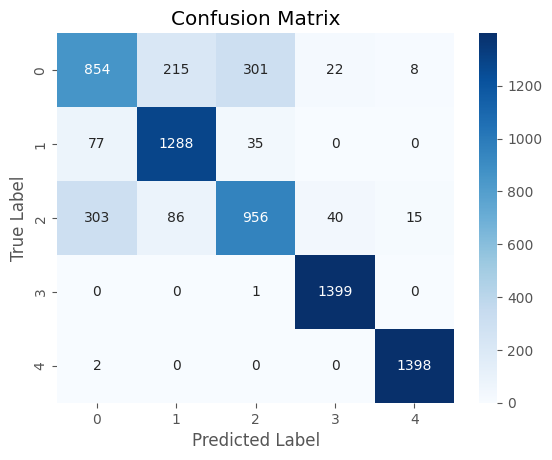

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_val_straight, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_val_straight, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1400
           1       0.81      0.92      0.86      1400
           2       0.74      0.68      0.71      1400
           3       0.96      1.00      0.98      1400
           4       0.98      1.00      0.99      1400

    accuracy                           0.84      7000
   macro avg       0.84      0.84      0.84      7000
weighted avg       0.84      0.84      0.84      7000

